<i><b>Public-AI</b></i>
### ✎&nbsp;&nbsp;week 6. Neural Collaborative Filtering와 DeepFM

# 컨텍스트 데이터와 DeepFM

현실세계에서는 구매하는 환경에 따라 아이템에 대한 고객의 행동이 변화합니다. 여기서, "구매하는 환경"을 "문맥(Context)"라고 하며, 이를 기반으로한 추천시스템을 "문맥기반 추천시스템"이라 불리는데요, 최근 2020년의 트렌드 키워드로 "초개인화"가 언급되면서 특히 주목받고 있는 추천시스템 기술이기도 합니다. 우리는 초개인화 추천시스템을 구현하기 위해서 컨텍스트 데이터가 가진 매우 복잡한 상호관계의 특성을 활용하게 됩니다. 이번시간에는 이러한 복잡한 상호관계를 딥러닝으로 모델링한 DeepFM에 대해서 구현해보겠습니다. 

### _Objective_ 

* 고객 행동 및 컨텍스트 데이터을 이용하는 방법을 배웁니다.
* 특성간 복잡한 관계에 있는 데이터에서 추천시스템을 구현합니다.
* DeepFM을 직접 구현하여 현업에서 필요에 맞게 활용합니다.


In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

# \[ 1. 문제 정의 \]
---

이전시간에 배운 FM모델은 각 특성 간의 Pair-wise의 상호관계를 임베딩하여 활용하는 방법이었습니다. 하지만, 현실세계에서 구매가 진행되는 상황에는 고객과 유저의 특성뿐 아니라 그 환경에 대한 정보도 있을 것입니다. 이러한 "환경에 대한 정보"인 컨텍스트 데이터를 다루는 문제를 살펴봅시다.

## 컨텍스트 데이터(Context data)

유저의 아이템에 대한 활동이 있을 때 그 순간의 환경에 대한 데이터를 `컨텍스트 데이터(Context Data)` 즉, 문맥/환경 데이터라고 합니다. 현실세계에서 유저는 특성 시점에서 이러한 문맥과 환경의 영향을 받아 구매나 소비가 발생하게 되는데요, 예컨데 "나는 비가오는 날 운동할 때에는 트와이스의 "cheer up" 노래가 듣고싶어진다." 같은 것입니다.<br>
컨텍스트 데이터는 고객의 행동에 대한 시점에 따라 달라지기 때문에, 각 로그데이터(상호작용데이터)마다 서로 다른 값들을 갖게 됩니다. 다시 말해서, `상호작용이 발생하는 시점`에서 현재 상호작용에 영향을 끼치고 있는 데이터를 `컨텍스트 데이터`라고 할 수 있습니다. ( 고객정보, 상품정보 데이터는 "해당 시점"의 데이터는 아님 )<br>
추천시스템의 문맥/환경을 고려한 접근은 최근 서비스 트렌드인 "초개인화"의 활약으로 전 세계적인 관심을 받고 있습니다. 특히 세계 최대의 온라인 쇼핑 중개기업인 "아마존"에서는 이러한 컨텍스트 데이터를 활용하여 고객을 세분화하여 "0.1인 마케팅"을 실현하는 것으로도 유명합니다.
이제, 우리도 서비스를 이용하는 고객의 상황까지 고려하는 초개인화 추천시스템을 만들어 보겠습니다.

## 특성간의 복잡한 상호관계

`컨텍스트 데이터`는 이전시간에 배운 Factorization Machine 모델로 단순히 각 특성간 pair-wise의 상호관계만을 고려하기에는 정말 복잡한 상호관계를 가지고 있습니다. 예를 들자면, "일하는 시간" , "비오는 날씨", "아티스트"는 단순히 (시간, 날씨), (날씨, 직업), (시간, 직업)과 같이 쌍(pair)로만 상호관계를 갖는 것이 아닙니다. (시간, 날씨, 직업)을 함께 고려한 상호작용이 고객의 행동에 영향을 미치게 되지요. 여러가지의 각 특성들은 더욱 복잡하게 관계되어 고객의 행동에 영향을 끼치게 됩니다.<br>
이렇듯 쌍 이상의 상호관계를 `Order-N` 이라 표현합니다.

### Order-N 상호관계

+ Order-0 : 각 특성(Feature)의 가중치를 전혀 고려하지 않음 : bias 부분
+ Order-1 : 특성 각각의 값에 대한 영향 고려 : Linear Regression Model 부분
+ Order-2 : 특성 각각의 Pair에 대한 상호 관계의 영향 고려 : Factorization Machine Model 부분
+ Order-N : 특성간 서로 세 단계 이상으로 상호간 복잡한 관계의 영향 고려 : DeepLearning Model 부분

![](https://i.imgur.com/hcFGGnI.png)

예시 :
1. app-category, time-stamp : (점심시간에는 음식 배달앱을 많이 쓴다.) ; 두가지 특성의 상호작용의 반영을 order-2
2. app-category, user_age, user_gender : (10대 남자는 알피지 게임을 많이 쓴다.) ;  세가지 특성의 상호작용의 반영을 order-3

이렇게, 쌍이상의 복잡한 상호관계가 엮여있는 것을 order-N이라고 합니다. 앞서 배웠던 Linear Regression 모델은 Order-1 을 반영하고, Factorization Machine 모델은 Order-2 를 반영합니다. (global bias가 Order-0를 반영합니다.)

하지만 컨텍스트 데이터는 여러가지 특성의 복잡한 관계가 유저의 행동에 영향을 주므로 Order-N 인 high-order를 반영하는 추천 모델을 만드는 것이 이번 시간의 문제 정의입니다.

그렇다면, 이제 이러한 Order-N 관계의 컨텍스트 데이터가 있는 Frappe Dataset을 직접 확인해 보겠습니다.

## 1. Frappe Dataset

![](https://i.imgur.com/aNlJHCG.png)

Frappe 데이터는 2015년 5월에 컨텍스트 인지 모바일 앱 추천시스템을 위해 공개된 현실 데이터인데요, 유저의 앱에 대한 사용 카운트가 96200여개의 로그로 구성되어있는 데이터입니다.
 [데이터셋 페이퍼](https://arxiv.org/pdf/1505.03014v1.pdf)<br>

In [2]:
from tensorflow.keras.utils import get_file

ROOT_URL = "https://pai-datasets.s3.ap-northeast-2.amazonaws.com/recommender_systems/frappe/"

# 데이터 가져오기
frappe_path = get_file("frappe.csv", ROOT_URL+"frappe.csv")
meta_path = get_file("frappe_meta.csv", ROOT_URL+"meta.csv")

frappe_df = pd.read_csv(frappe_path)
meta_df = pd.read_csv(meta_path,sep='\t')

6217728/6215800 [==============================] - 1s 0us/step


### 1) 문제정의와 부합하는 데이터 확인

frappe 데이터 셋에는 이번 시간에 다뤄볼 문제와 같이 각 행에는 특정 고객이 특정 아이템을 다운로드하는 환경이 저장되어 있습니다.<br>
각 행은 고객의 아이템에 대한 행동로그데이터로 볼 수 있습니다.

**(1) frappe 데이터셋**

+ user : 유저 식별자
+ item : 아이템(앱) 식별자(\* meta.csv)
+ daytime : 시간대 구분 ( morning ~ night )
+ weekday : 요일 구분 ( monday ~ sunday )
+ isweekend : 주말/주중 구분 ( workday/weekend )
+ homework : 업무중/가정 구분 ( work/home/unknown )
+ cost : 유/무료 구분( free/paid )
+ weather : 날씨 구분( cloudy ~ unknown )
+ country : 국가 구분( Albania ~ unknown )
+ city : 도시 코드( 0 ~ 1087 )
+ cnt : 카운트

In [3]:
print("frappe_df 크기 : ",frappe_df.shape)
# 다섯개 데이터를 Random으로 가져옴
frappe_df.sample(5)

frappe_df 크기 :  (93308, 11)


,user,item,daytime,weekday,isweekend,homework,cost,weather,country,city,cnt
40362,126,239,afternoon,saturday,weekend,unknown,free,cloudy,United States,0,1
92870,758,16,morning,saturday,weekend,unknown,free,unknown,unknown,0,9
30560,89,168,morning,tuesday,workday,home,free,rainy,Canada,136,2
82478,377,5,morning,tuesday,workday,unknown,free,cloudy,Peru,799,91
70527,270,722,morning,saturday,weekend,home,free,sunny,Spain,369,27


**(2) meta 데이터셋**


In [4]:
meta_df.columns

Index(['item', 'package', 'category', 'downloads', 'developer', 'icon',
       'language', 'description', 'name', 'price', 'rating', 'short desc'],
      dtype='object')

In [5]:
print("meta_df 크기 : ",meta_df.shape)
# 세개 데이터를 Random으로 가져옴
meta_df.sample(3, random_state=123)

meta_df 크기 :  (4082, 12)


,item,package,category,downloads,developer,icon,language,description,name,price,rating,short desc
902,902,com.withings.wiscale2,Health & Fitness,"5,000 - 10,000",Withings,http://d2lh3rxs7crswz.cloudfront.net/com.withi...,en,The Withings Health Companion is the simple wa...,Withings Health Companion,Free,3.5,NaN
841,841,com.mobilefootie.fotmobpro,Sports,"10,000 - 50,000",NorApps,http://d2lh3rxs7crswz.cloudfront.net/com.mobil...,en,Over 3 million downloads for the best soccer/f...,Soccer Scores Pro - FotMob,$2.66,4.5,Follow your favorite football/soccer team. LIV...
2157,2157,com.srsdev.wallpapers,Personalization,"10,000,000 - 50,000,000",srsdev,http://d2lh3rxs7crswz.cloudfront.net/com.srsde...,en,** The BIGGEST collection of TOP QUALITY wallp...,"PicSpeed HD Wallpapers 500,000",Free,4.7,Simple and easy to use wallpaper application. ...


### 2) 데이터 탐색하기 - 컨텍스트 데이터

In [6]:
frappe_df.nunique()

user          792
item         2072
daytime         7
weekday         7
isweekend       2
homework        3
cost            2
weather         9
country        78
city          223
cnt          1978
dtype: int64

In [7]:
for col in frappe_df.drop(["user", "item", "city", "cnt"], axis=1):
    print("{} \n : {}\n".format(col, frappe_df[col].unique()))

daytime 
 : ['morning' 'afternoon' 'evening' 'sunset' 'night' 'sunrise' 'noon']

weekday 
 : ['sunday' 'friday' 'tuesday' 'wednesday' 'saturday' 'monday' 'thursday']

isweekend 
 : ['weekend' 'workday']

homework 
 : ['unknown' 'home' 'work']

cost 
 : ['free' 'paid']

weather 
 : ['sunny' 'cloudy' 'drizzle' 'rainy' 'unknown' 'foggy' 'stormy' 'snowy'
 'sleet']

country 
 : ['United States' 'Spain' 'unknown' 'Switzerland' 'Italy' 'India' 'Canada'
 'France' 'United Kingdom' 'Greece' 'Peru' 'Lithuania' 'Poland' 'Israel'
 'Palestine' 'Belgium' 'Slovenia' 'Ecuador' 'Mexico' 'Andorra'
 'Netherlands' 'Australia' 'Germany' 'Cyprus' 'Austria' 'Hong Kong'
 'Denmark' 'Sweden' 'Costa Rica' 'Morocco' 'Colombia' 'Iraq' 'Russia'
 'Czech Rep.' 'Taiwan' 'Norway' 'New Zealand' 'Chile' 'South Africa'
 'Macedonia' 'Kosovo' 'Bosnia and Herz.' 'Bulgaria' 'Montenegro' 'Albania'
 'Saudi Arabia' 'Japan' 'Iran' 'Korea' 'Ireland' 'Brazil' 'Argentina'
 'United Arab Emirates' 'Indonesia' 'Malaysia' 'Croatia' 'Hung

**(1) 유저별 활용 아이템의 수**

In [8]:
avg_items_per_user = (
    frappe_df
    [["user", "item"]]
    .drop_duplicates()
    .groupby("user")
    .count()["item"]
    .mean()
)
print("유저별 활용 아이템의 수 : ", avg_items_per_user)

유저별 활용 아이템의 수 :  20.80429292929293


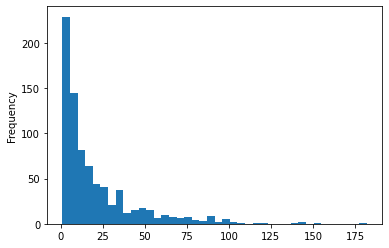

In [9]:
(
    frappe_df
    [["user", "item"]]
    .drop_duplicates()
    ["user"]
    .value_counts()
    .plot(kind="hist", bins=40)
)

plt.show()

**(2) 아이템 별 카운트 수**

In [10]:
avg_cnt_per_item = (
    frappe_df
    .loc[:, ["item", "cnt"]]
    .groupby("item")
    .sum()["cnt"]
    .mean()
)
print("아이템 별 활용 아이템의 수 : ", avg_cnt_per_item)

아이템 별 활용 아이템의 수 :  3748.007722007722


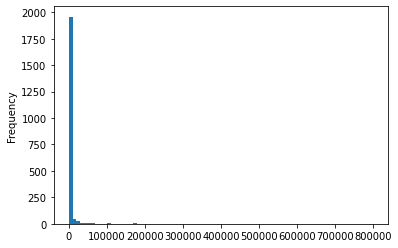

In [11]:
(
    frappe_df
    .loc[:, ["item", "cnt"]]
    .groupby("item")
    .sum()["cnt"]
    .sort_values(ascending=False)
    .plot(kind="hist", bins=80)
)

plt.show()

In [12]:
# 상위 10개 앱의 이름 가져오기
top10_indices = (
    frappe_df
    [["item", "cnt"]]
    .groupby("item")
    ['cnt']
    .sum()
    .sort_values(ascending=False)
    .iloc[:10]
    .index)
meta_df.loc[meta_df.item.isin(top10_indices),['name']]

,name
5,WhatsApp Messenger
9,Maps
11,Twitter
16,Facebook
17,Google Search
21,Gmail
25,Chrome
33,Nova Launcher
40,Candy Crush Saga
65,YouTube


**(3) daytime과 weekday별 Count수 차이**

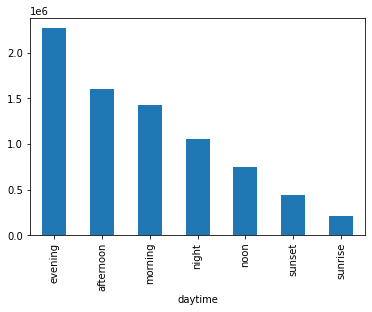

In [13]:
(
    frappe_df
    .loc[:, ["daytime", "cnt"]]
    .groupby("daytime")
    .sum()
    ["cnt"]
    .sort_values(ascending=False)
    .plot(kind="bar")
)
plt.show()

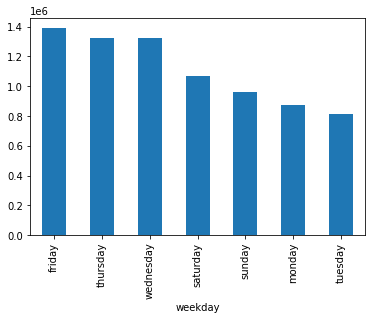

In [14]:
# weekday에 따른 count수 합 차이
(
    frappe_df
    .loc[:, ["weekday", "cnt"]]
    .groupby("weekday")
    .sum()
    ["cnt"]
    .sort_values(ascending=False)    
    .plot(kind="bar")
)
plt.show()

### 3) 상호작용 효과 파악하기

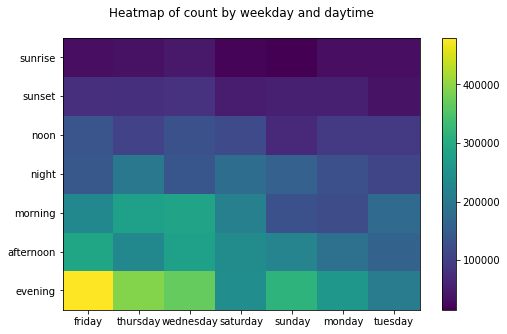

In [15]:
# 카운트 수에 따른 요일과 시간구간의 순서
order_weekday = (
    frappe_df
    .loc[:, ["weekday", "cnt"]]
    .groupby("weekday")
    .sum()
    .sort_values("cnt", ascending=False)
    .index
)

order_daytime = (
    frappe_df
    .loc[:, ["daytime", "cnt"]]
    .groupby("daytime")
    .sum()
    .sort_values("cnt", ascending=False)
    .index
)

# weekday와 Daytime에 따른 count수 합 차이
heat_df = (
    frappe_df
    .loc[:, ["weekday", "daytime","cnt"]]
    .pivot_table(values=["cnt"], index=["daytime"], columns=['weekday'], aggfunc=np.sum)
    ["cnt"]
    .loc[order_daytime, order_weekday]
)

plt.figure(figsize=(8,5))
plt.pcolor(heat_df)
plt.title("Heatmap of count by weekday and daytime\n")
plt.yticks(np.arange(0.5, len(heat_df.index), 1), heat_df.index)
plt.xticks(np.arange(0.5, len(heat_df.columns), 1), heat_df.columns)
plt.colorbar()
plt.show()

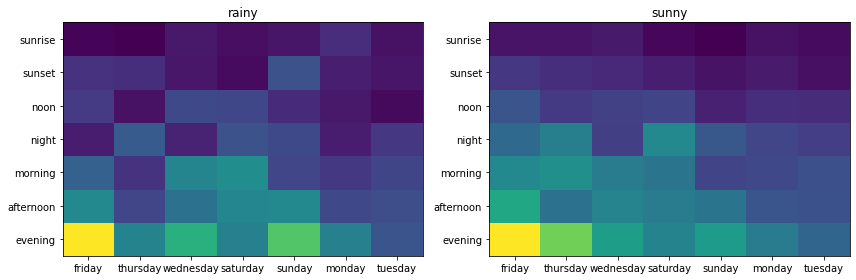

In [16]:
# 날씨에 따른 두 히트맵의 변화
# rainy 일 때
rainy_heat_df = (
    frappe_df
    .loc[frappe_df["weather"] == "rainy", ["weekday", "daytime","cnt"]]
    .pivot_table(values=["cnt"], index=["daytime"], columns=['weekday'], aggfunc=np.sum)
    ["cnt"]
    .reindex(order_daytime, columns=order_weekday)
)

# sunny 일 때
sunny_heat_df = (
    frappe_df
    .loc[frappe_df["weather"] == "sunny", ["weekday", "daytime","cnt"]]
    .pivot_table(values=["cnt"], index=["daytime"], columns=['weekday'], aggfunc=np.sum)
    ["cnt"]
    .reindex(order_daytime, columns=order_weekday)
)

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,4))

plt.setp(axes, 
         xticks=np.arange(0.5, len(rainy_heat_df.columns), 1), 
         xticklabels=rainy_heat_df.columns,
         yticks=np.arange(0.5, len(heat_df.index), 1),
         yticklabels=heat_df.index,
)

plt.sca(axes[0])
plt.pcolor(rainy_heat_df)
plt.title('rainy')

plt.sca(axes[1])
plt.pcolor(sunny_heat_df)
plt.title('sunny')

fig.tight_layout()
plt.show()

### 3) 데이터 탐색하기 - 아이템 컨텐츠 데이터(특성 데이터)

meta_df 에는 각 item 의 특성들이 저장되어있습니다. 이를 확인해 보겠습니다.

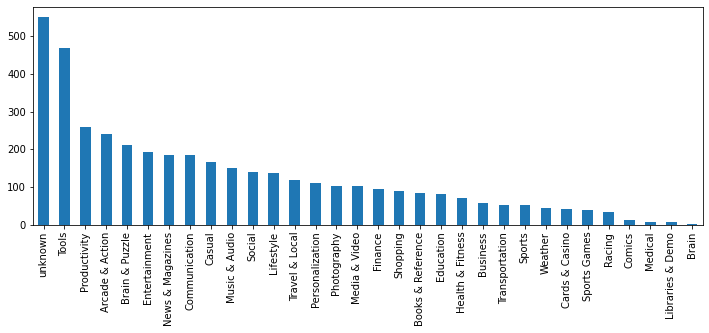

In [17]:
# 앱의 개수별
(
    meta_df
    ["category"]
    .value_counts(ascending=False)
    .plot(kind="bar",figsize=(12,4))
)
plt.show()

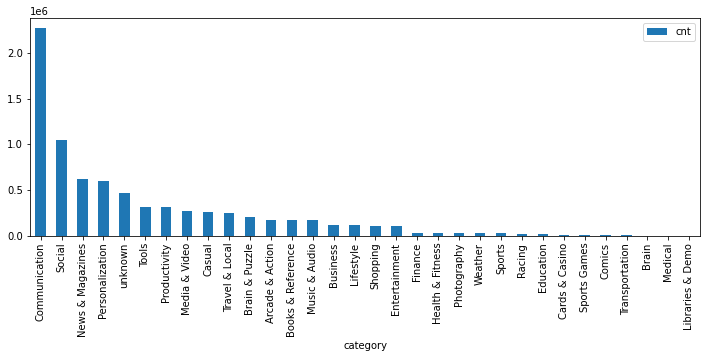

In [18]:
# Category 별 총 카운트 수 비교
merged_df = pd.merge(frappe_df, meta_df.loc[:, ["item", "category"]], on="item" )

(
    merged_df[["category", "cnt"]]
    .groupby("category")
    .sum()
    .sort_values(by="cnt", ascending=False)
    .plot(kind="bar", figsize=(12,4))
)
plt.show()

Meta_df 데이터셋은 추천할 아이템이 무엇인지 확인할 때 사용하도록 합시다.

## 2 . 문제정의 및 목표 설정

살펴본 Frappe Dataset을 통해 각 컬럼을 다음과 같이 정리할 수 있습니다.<br>

![](https://i.imgur.com/RVO0ZYI.png) 

추천 목적에 따라서 추천시스템의 알고리즘과 측정 방법 등이 크게 달라집니다. 따라서, 우리는 주어진 데이터로 구성할 추천시스템의 목적을 명확히 할 필요가 있습니다. 이번 Frappe Dataset이라면 다음과 같은 시나리오를 구성해 볼 수 있겠지요.

1. 현재 상황에서 특정 어플이 없는 유저(user)에게 어플 추천 광고 집행
2. 특정 어플이 있는 유저에게 사용량(cnt)을 더욱 증가시키기 위해 상황에 따른 알림
3. 고객에게 상황에 따른 어플 내부 결제 유도 쿠폰 제공
4. 특정어플을 고객이 다양한 환경에서 사용하도록 유도하는 최적의 알림 타이밍
5. ... 등등

이러한 시나리오에 나타나는 추천시스템의 특성이나 목적, 상황에 따라 도메인지식을 활용하여 필요한 추천시스템에 대한 문제를 정의해야 합니다. 이번 시간에는 "특정 상황에서 고객이 한번 쯤 사용해볼 것 같은 어플을 찾는 추천시스템"으로 목표를 설정해 보겠습니다. 즉, 특정 상황에서 유저가 한번도 사용하지 않았던 어플 중 가장 관심있어 할만한 어플을 찾아주는 문제로 정의할 수 있습니다.<br>

따라서, 이번시간에 우리가 다루는 Frappe 데이터 또한 "특정상황에서 실행했던 앱이라면 `True`로 설정"하여 다루고자 합니다. 문제는 아래와 같이 바꿔줄 수 있습니다.

In [19]:
# 기존의 cnt(count) 의 형태 -> 특정 환경에서 해당 어플을 몇번 열었는가
frappe_df.cnt

0         1
1         2
2         9
3         2
4         1
         ..
93303     1
93304     1
93305    13
93306     3
93307     3
Name: cnt, Length: 93308, dtype: int64

In [20]:
# 다음과 같이, 1번 이상 로그가 있는 Context 에 대해서는 모두 "클릭을 했다" 라는 의미로 `True`로 변경해주었습니다.
frappe_df["cnt"] = True
frappe_df.cnt

0        True
1        True
2        True
3        True
4        True
         ... 
93303    True
93304    True
93305    True
93306    True
93307    True
Name: cnt, Length: 93308, dtype: bool

# \[ 2. 기본 개념 \] 
---



## 1.DeepFM의 구조

[논문 DeepFM: A Factorization-Machine based Neural Network for CTR Prediction](https://arxiv.org/pdf/1703.04247.pdf)<br>
이번시간에 배울 DeepFM의 구조는 다음과 같습니다.<br>

![deepFM의 구조](https://i.imgur.com/qkpnkrH.png)

## 2. DeepFM의 아이디어와 특징

### 특징 1. 각 피쳐의 임베딩을 FM모델과 DeepLearning 모델이 공유하고 있다.

피쳐 엔지니어링에 들어가는 수고를 많이 덜어낼 수 있습니다.

### 특징 2. 미리 학습(Pre-trained)하지 않고 한번의 Input으로 End-to-end로 진행한다.

다른 모델의 경우 FM으로 미리 한번 학습된 Embedding으로 Deeplearning모델을 학습하는 경우가 있습니다. 한번에 모델을 학습시킬 수 있으므로, 학습의 어려움이 적습니다.


# \[ 3. 알고리즘 \]
---

## 2. deepFM 모델 구성하기

### (1) 입력부분 구성하기

모델의 입력 변수로는 아래의 것들이 필요합니다. 

* $x_{user}$
* $x_{item}$
* $x_{daytime}$
* $x_{weekday}$
* $x_{isweekend}$
* $x_{homework}$
* $x_{cost}$
* $x_{weather}$
* $x_{country}$
* $x_{city}$

In [21]:
frappe_df.head(5)

,user,item,daytime,weekday,isweekend,homework,cost,weather,country,city,cnt
0,0,0,morning,sunday,weekend,unknown,free,sunny,United States,0,True
1,0,9,afternoon,friday,workday,unknown,free,cloudy,United States,1023,True
2,0,9,evening,friday,weekend,unknown,free,cloudy,United States,1023,True
3,0,14,afternoon,friday,workday,unknown,free,cloudy,United States,1023,True
4,0,16,evening,friday,weekend,unknown,free,cloudy,United States,1023,True


현재 모든 데이터는 명목형 변수, 즉 카테고리형 데이터로 입력값의 형태는 0차원, 즉 Index로만 존재하게 됩니다.

In [22]:
for col_name in frappe_df.columns:    
    print(f"{col_name}의 데이터 구성: {frappe_df[col_name].shape}\n")

user의 데이터 구성: (93308,)

item의 데이터 구성: (93308,)

daytime의 데이터 구성: (93308,)

weekday의 데이터 구성: (93308,)

isweekend의 데이터 구성: (93308,)

homework의 데이터 구성: (93308,)

cost의 데이터 구성: (93308,)

weather의 데이터 구성: (93308,)

country의 데이터 구성: (93308,)

city의 데이터 구성: (93308,)

cnt의 데이터 구성: (93308,)



위의 구성에서 93308은 데이터의 갯수를 의미하는 축이고, 데이터의 Shape은 이후 숫자가 데이터의 Shape이 됩니다. 현재 각 데이터의 Shape은 0차원입니다.
이러한 데이터를 입력받기 위해서는 차원이 ()인 `Input`레이어를 만들어 주어야 합니다.

In [23]:
from tensorflow.keras.layers import Input

inputs = {}
for col_name in frappe_df.columns:
    if col_name == 'cnt':
        # 종속 변수는 입력값에서 제거
        continue
    
    x = Input(shape=(), name=col_name)
    inputs[col_name] = x

In [24]:
inputs

{'user': <tf.Tensor 'user:0' shape=(None,) dtype=float32>,
 'item': <tf.Tensor 'item:0' shape=(None,) dtype=float32>,
 'daytime': <tf.Tensor 'daytime:0' shape=(None,) dtype=float32>,
 'weekday': <tf.Tensor 'weekday:0' shape=(None,) dtype=float32>,
 'isweekend': <tf.Tensor 'isweekend:0' shape=(None,) dtype=float32>,
 'homework': <tf.Tensor 'homework:0' shape=(None,) dtype=float32>,
 'cost': <tf.Tensor 'cost:0' shape=(None,) dtype=float32>,
 'weather': <tf.Tensor 'weather:0' shape=(None,) dtype=float32>,
 'country': <tf.Tensor 'country:0' shape=(None,) dtype=float32>,
 'city': <tf.Tensor 'city:0' shape=(None,) dtype=float32>}

### (1) 선형회귀 부분 구성하기 (Order-1)

$$
logits_{LR} = bias + W_{user} X_{user} + W_{item} X_{item} + W_{daytime} X_{daytime} + \cdots
$$

여기서 명목형 변수는 결국 인덱싱으로 들어가게 되고 식의 구조는 아래와 같이 가중치의 합으로 표현되게 됩니다.

$$
logits_{LR} = bias + w_{user} + w_{item} + w_{daytime} + \cdots
$$

In [25]:
from tensorflow.keras.layers import Embedding

linear_embeds = []
for col_name in frappe_df.columns:
    if col_name == 'cnt':
        continue
    num_category = frappe_df[col_name].nunique()        
        
    x = inputs[col_name]
    lr_out = Embedding(num_category, 1,
                       name=f'{col_name}_lr_embed')(x)
    linear_embeds.append(lr_out)

In [26]:
linear_embeds

[<tf.Tensor 'user_lr_embed/Identity:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'item_lr_embed/Identity:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'daytime_lr_embed/Identity:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'weekday_lr_embed/Identity:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'isweekend_lr_embed/Identity:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'homework_lr_embed/Identity:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'cost_lr_embed/Identity:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'weather_lr_embed/Identity:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'country_lr_embed/Identity:0' shape=(None, 1) dtype=float32>,
 <tf.Tensor 'city_lr_embed/Identity:0' shape=(None, 1) dtype=float32>]

#### Linear Regression을 위한 Custom 연산층 구성하기

우리는 위에서 가져온 모든 가중치들을 더해주면 됩니다.

In [27]:
from tensorflow.keras.layers import Layer

class LinearModel(Layer):
    """
    Linear Logit
    y = w0 + w1 + w2 + ...
    """
    def build(self, input_shape):
        self.b = self.add_weight(shape=(1,),
                                 initializer='zeros',
                                 trainable=True)
        super().build(input_shape)    
    
    def call(self, inputs, **kwargs):
        logits = tf.add_n(inputs) + self.b
        return logits

In [28]:
lr_logits = LinearModel(name='lr')(linear_embeds)
lr_logits

<tf.Tensor 'lr/Identity:0' shape=(None, 1) dtype=float32>

### (2) Factorization 부분 구성하기 (Order-2)

In [29]:
fm_size = 5

fm_embeds = []
for col_name in frappe_df.columns:
    if col_name == 'cnt':
        continue
    num_category = frappe_df[col_name].nunique()

    x = inputs[col_name]
    
    # 임베딩 행렬 선언하기
    embedding_layer = Embedding(num_category, fm_size,
                       name=f'{col_name}_fm_embed')
    embed_out = embedding_layer(x)
    
    # 출력된 임베딩 벡터 담기
    fm_embeds.append(embed_out)
    
    weight = embedding_layer.get_weights()[0]
    print(f"{col_name}에 대한 임베딩 행렬 : {weight.shape}")

user에 대한 임베딩 행렬 : (792, 5)
item에 대한 임베딩 행렬 : (2072, 5)
daytime에 대한 임베딩 행렬 : (7, 5)
weekday에 대한 임베딩 행렬 : (7, 5)
isweekend에 대한 임베딩 행렬 : (2, 5)
homework에 대한 임베딩 행렬 : (3, 5)
cost에 대한 임베딩 행렬 : (2, 5)
weather에 대한 임베딩 행렬 : (9, 5)
country에 대한 임베딩 행렬 : (78, 5)
city에 대한 임베딩 행렬 : (223, 5)


#### 상호작용 연산 부분을 위한 Custom 연산층 구성하기

$$logits_{fm} =  \sum^n_{i=1}\sum^n_{j=i+1}\langle \mathbf{v}_i,\mathbf{v}_j \rangle x_ix_j$$

위의 수식을 보다 빠르게 계산하기 위해 식을 정리하면 아래와 같은 꼴로 정리됩니다.

$$ logits_{fm} = \frac{1}{2} \sum^k_{f=1}\Bigg(\bigg(\sum^n_{i=1}v_{i,f}x_i\bigg)^2 - \sum^n_{i=1}v^2_{i,f}x^2_i\Bigg) $$


In [30]:
class FactorizationMachine(Layer):
    """
    Factorization Machine Layer
    """
    def call(self, inputs, **kwargs):
        # List of (# Batch, # Embed) -> (# Batch, # Features ,# Embed)
        inputs = tf.stack(inputs, axis=1) 
        
        logits = tf.reduce_sum(
            tf.square(tf.reduce_sum(inputs, axis=1))
            - tf.reduce_sum(tf.square(inputs), axis=1)
            , axis=1, keepdims=True) / 2.
        return logits

In [31]:
fm_logits = FactorizationMachine(name='fm')(fm_embeds)

### (3) DeepFM 부분 구성하기 (Order-3)

#### 상호작용 임베딩 벡터를 하나의 벡터로 붙이기

In [32]:
from tensorflow.keras.layers import Concatenate

deep_inputs = Concatenate()(fm_embeds)

In [33]:
deep_inputs

<tf.Tensor 'concatenate/Identity:0' shape=(None, 50) dtype=float32>

#### Dense Layer를 통한 MLP 구현하기

In [34]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

h = Dense(100, 'relu')(deep_inputs)
h = Dropout(0.5)(h)
h = Dense(100, 'relu')(h)
h = Dropout(0.5)(h)
h = Dense(100, 'relu')(h)
h = Dropout(0.5)(h)
deep_logits = Dense(1)(h)

In [35]:
deep_logits

<tf.Tensor 'dense_3/Identity:0' shape=(None, 1) dtype=float32>

### (4) 출력층 구성하기


In [36]:
from tensorflow.keras.activations import sigmoid
from tensorflow.keras.layers import Add

logits = Add()([lr_logits, fm_logits, deep_logits])
pred = sigmoid(logits)

In [37]:
pred

<tf.Tensor 'Sigmoid:0' shape=(None, 1) dtype=float32>

### (5) 모델 인스턴스 생성하기

In [38]:
from tensorflow.keras.models import Model

model = Model(inputs, pred, name='frappe_deepfm')

### (6) 모델 컴파일하기

#### Regularization 부분 구성하기

In [39]:
l2_loss = 1e-4 * (tf.reduce_sum([embed **2 for embed in linear_embeds]) 
                  + tf.reduce_sum([embed **2 for embed in fm_embeds]))
model.add_loss(l2_loss)

#### Optimizer와 Loss 구성하기

In [40]:
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import Adagrad

In [41]:
optm = Adagrad(learning_rate=.1)
mse_loss = losses.BinaryCrossentropy()
metric_list = [metrics.BinaryCrossentropy()]

# model에 컴파일하여 loss 및 옵티마이저 적용
model.compile(optimizer=optm,
              loss=mse_loss, 
              metrics=metric_list)

## 3. 데이터 구성하기

### (1) 명목형 데이터의 인덱싱 표 만들기

명목형 데이터에서 각 값을 임베딩 행렬에서 몇 번째 벡터를 가르키는지를 지칭하는 임베딩 인덱스로 바꾸어 주기 위해서, 인덱싱 표를 생성합니다.

In [42]:
def cate2int(df):
    df = df.copy()
    cate_sizes = {}
    cate_mapper = {}
    for col_name in df.columns:
        if col_name == 'cnt':
            continue
        df.loc[:, col_name] = df.loc[:, col_name].astype('category')
        
        if pd.api.types.is_categorical_dtype(df[col_name]):
            cate_mapper[col_name] = {c:i for i, c in enumerate(df[col_name].cat.categories)}
            cate_sizes[col_name] = len(df[col_name].cat.categories)
            df.loc[:,col_name] = df[col_name].cat.codes
    return cate_mapper, cate_sizes

In [43]:
cate_mapper, cate_sizes = cate2int(frappe_df)

### (2) trainset과 testset으로 구분하기

학습데이터셋과 테스트 데이터 셋을 분리합니다. 이 때, 테스트데이터셋은 무작위로 10%를 분리하였습니다.


In [44]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(frappe_df, test_size=0.1)

### (3) 각 값을 indexing으로 변경하기

각 열의 값들을 임베딩 행렬의 인덱스 값으로 바꾸어줍니다. 

In [45]:
display(train_df.head())
for col_name, category in cate_mapper.items():
    train_df[col_name] = train_df[col_name].map(category)
    
display(train_df.head())

,user,item,daytime,weekday,isweekend,homework,cost,weather,country,city,cnt
10256,33,552,night,friday,workday,unknown,free,cloudy,Ecuador,356,True
21278,66,911,afternoon,saturday,weekend,unknown,free,rainy,United States,1022,True
85778,410,232,evening,wednesday,workday,unknown,free,cloudy,Spain,369,True
81862,366,1630,morning,monday,workday,unknown,free,unknown,Philippines,805,True
82958,378,290,night,saturday,weekend,unknown,free,sunny,United States,0,True


/Users/ksj/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,user,item,daytime,weekday,isweekend,homework,cost,weather,country,city,cnt
10256,33,506,3,0,1,1,0,0,18,52,True
21278,65,801,0,2,0,1,0,3,75,196,True
85778,405,217,1,6,1,1,0,0,67,58,True
81862,362,1338,2,1,1,1,0,8,56,151,True
82958,373,269,3,2,0,1,0,7,75,0,True


In [46]:
display(test_df.head())
for col_name, category in cate_mapper.items():
    test_df.loc[:,col_name] = test_df[col_name].map(category)
    
display(test_df.head())

,user,item,daytime,weekday,isweekend,homework,cost,weather,country,city,cnt
68871,259,453,evening,monday,workday,unknown,free,sunny,Egypt,360,True
58111,194,17,afternoon,monday,workday,unknown,free,cloudy,New Zealand,789,True
42640,133,16,evening,thursday,workday,unknown,free,cloudy,United States,0,True
66229,245,78,afternoon,sunday,weekend,unknown,free,cloudy,United States,0,True
12095,39,26,afternoon,thursday,workday,unknown,free,cloudy,United States,1031,True


/Users/ksj/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


,user,item,daytime,weekday,isweekend,homework,cost,weather,country,city,cnt
68871,257,419,1,1,1,1,0,7,19,54,True
58111,193,15,0,1,1,1,0,0,51,144,True
42640,132,14,1,4,1,1,0,0,75,0,True
66229,243,76,0,3,0,1,0,0,75,0,True
12095,39,24,0,4,1,1,0,0,75,203,True


### (3) 네거티브샘플링 적용하기

현재 해당 데이터는 특정 컨택스트에서 고객의 앱에 대한 사용 여부로서 "Positive" 데이터만 존재하고 있습니다. 즉, 고객 행동의 긍정적인 행동만 기록되어있다는 것입니다. 우리는 고객이 클릭하지 않은 앱에 대한 사용 여부, 즉 Positive 데이터 한개당 Negative 데이터 3개씩을 생성하되 item 이외의 다른 feature는 고정하고 item을 무작위로 결정하는 식으로 진행해보도록 하겠습니다.<br>

In [47]:
def do_negative_sampling(df, negative_sampling_ratio=3):
    # 네거티브 데이터 총 개수만큼 생성
    negative_sampled_df = pd.concat([df]*int(negative_sampling_ratio))
    # item 식별자를 무작위로 부여
    negative_sampled_df.item = (df
                                .item
                                .sample(len(df)*negative_sampling_ratio,replace=True) 
                                .values) 
    # "네거티브 데이터"는 카운트가 존재하지 않음    
    negative_sampled_df.cnt = 0
    # 포지티브 데이터와 네거티브 데이터를 합쳐줌
    sampling_df = pd.concat([df, negative_sampled_df]) 
    # 중복 된 데이터중 네거티브의 데이터를 제거
    sampling_df = sampling_df.drop_duplicates(sampling_df.columns.drop('cnt')) 
    sampling_df = sampling_df.sample(frac=1)
    return sampling_df

In [48]:
print("샘플링하기 전 학습데이터의 수 : {}".format(train_df.shape))
sampling_train_df = do_negative_sampling(train_df, 4)
print("샘플링된 학습데이터의 수 : {}".format(sampling_train_df.shape))

print("샘플링하기 전 학습데이터의 수 : {}".format(test_df.shape))
sampling_test_df = do_negative_sampling(test_df, 4)
print("샘플링된 학습데이터의 수 : {}".format(sampling_test_df.shape))

샘플링하기 전 학습데이터의 수 : (83977, 11)
샘플링된 학습데이터의 수 : (355681, 11)
샘플링하기 전 학습데이터의 수 : (9331, 11)
샘플링된 학습데이터의 수 : (43895, 11)


### (3) Input 과 Target 분리

데이터 중에서 종속 변수가 되는 요소들($X$)과 독립 변수가 되는 클릭 유무을 나누도록 하겠습니다.

In [49]:
X_train = sampling_train_df.drop("cnt", axis=1)
y_train = sampling_train_df[['cnt']]

X_test = sampling_test_df.drop('cnt', axis=1)
y_test = sampling_test_df[['cnt']]

### (4) 텐서로 바꾸어 주기

In [50]:
# keras에서 용이하게 활용할 수 있도록 데이터를 텐서로 변경해줍니다.
trainset = tf.data.Dataset.from_tensor_slices(
    ({k : v.values.astype(np.int32) 
      for k, v in X_train.iteritems()}, 
     y_train.values))

validset = tf.data.Dataset.from_tensor_slices(
    ({k : v.values.astype(np.int32) 
      for k, v in X_test.iteritems()}, 
     y_test.values))

## 4. 모델 학습하기

In [52]:
num_epoch = 50
batch_size = 512

for i in range(num_epoch):
    print("{}th epoch ".format(i))    
    sampling_df = do_negative_sampling(train_df, 3)
    X_train, y_train = sampling_df.drop("cnt", axis=1), sampling_df[['cnt']]

    trainset = tf.data.Dataset.from_tensor_slices(
        ({k : v.values.astype(np.int32) 
          for k, v in X_train.iteritems()}, 
         y_train.values))

    hist = model.fit((trainset.shuffle(batch_size*10).batch(batch_size)),
                      validation_data=validset.batch(batch_size*4), verbose=2)

0th epoch 
Train for 571 steps, validate for 22 steps
571/571 - 6s - loss: 0.5962 - binary_crossentropy: 0.5962 - val_loss: 0.5390 - val_binary_crossentropy: 0.5391
1th epoch 
Train for 571 steps, validate for 22 steps
571/571 - 4s - loss: 0.5924 - binary_crossentropy: 0.5924 - val_loss: 0.5374 - val_binary_crossentropy: 0.5374
2th epoch 
Train for 572 steps, validate for 22 steps
572/572 - 4s - loss: 0.5878 - binary_crossentropy: 0.5878 - val_loss: 0.5368 - val_binary_crossentropy: 0.5368
3th epoch 
Train for 571 steps, validate for 22 steps
571/571 - 4s - loss: 0.5800 - binary_crossentropy: 0.5799 - val_loss: 0.5306 - val_binary_crossentropy: 0.5306
4th epoch 
Train for 571 steps, validate for 22 steps
571/571 - 4s - loss: 0.5649 - binary_crossentropy: 0.5649 - val_loss: 0.5165 - val_binary_crossentropy: 0.5165
5th epoch 
Train for 571 steps, validate for 22 steps
571/571 - 4s - loss: 0.5425 - binary_crossentropy: 0.5425 - val_loss: 0.4908 - val_binary_crossentropy: 0.4906
6th epoch 

## 4. DeepFM 모델 활용하기 

### (1) 상황에 따른 아이템 추천

> 특정 상황에서 특정 유저가 사용하지 않았던 어떤 어플을 추천해 줄 것인가

In [ ]:
situation_sample = pd.Series({
    "user" : 4,
    "daytime" : "evening",
    "weekday" : "wednesday",
    "isweekend" : "workday",
    "homework": "work",
    "cost" : "free",
    "weather" : "sunny",
    "country" : "Switzerland",
    "city" : 147
})

### 추천가능한 아이템 후보군 만들기

In [ ]:
# 유저가 이미 가지고 있는 어플을 따로 빼주고자 한다.
user_have_item = (
    frappe_df
    .loc[frappe_df["user"] == situation_sample["user"], "item"]
    .unique()
)

In [ ]:
item_can = frappe_df.item.unique() # 추천 가능한 아이템의 카테고리
item_can = np.array(list(set(item_can) - set(user_have_item)))
sample_df = pd.DataFrame([situation_sample]*len(item_can)) # 모든 아이템에 대한 경우의 수로 데이터 프레임 만들기
sample_df["item"] = item_can # 각 행별로 아이템 적용

# 열 정리
sample_df = sample_df[frappe_df.columns[:-1]]

sample_df.sample(10)

### 학습된 모델을 통한 선호 예측

In [ ]:
# 입력 가능한 데이터셋 딕셔너리 형태로 수정
sampleset = {}
for cate, mapper in cate_mapper.items():
    sampleset[cate] = sample_df[cate].map(mapper).astype(np.int32)
    
# 모델을 통한 예측
prediction = model.predict(sampleset)
prediction

In [ ]:
# 예측 결과를 시리즈로 변경
prediction_series = pd.Series(data=prediction.flatten(), index=sample_df.item)

# 상위 3개의 아이템만 추려봄
recommend_items = prediction_series.sort_values(ascending=False).index[:3]

In [ ]:
# 아이템 메타데이터로부터 아이템 확인
meta_df.loc[meta_df.item.isin(recommend_items),:]

## 2. DeepFM 모델 활용하기 - 앱 마케팅 전략 수립

특정 상황에 이 아이템을 누구에게 홍보할 것인가

### 상황 가정

In [ ]:
# 현재 우리는 "Candy Crusy Sage" 어플의 마케터로서, 특성 상황에 대해 누구에게 홍보할 것인가 결정할 것입니다.
display(meta_df.loc[meta_df["item"] == 40, :])

situation_sample = pd.Series({
    "item" : 40,
    "daytime" : "noon",
    "weekday" : "wednesday",
    "isweekend" : "workday",
    "homework": "home",
    "cost" : "free",
    "weather" : "cloudy",
    "country" : "United States",
    "city" : 0 })

### 가능한 유저 상황의 데이터프레임 만들기

**해당 아이템을 다운받지 않은 유저 & 해당 국가의 유저**

In [ ]:
# 어플을 이미 가지고 있는 유저는 따로 빼주고자 한다.
item_have_user = (
    frappe_df
    .loc[frappe_df["item"] == situation_sample["item"] , "user"]
    .unique()
)

user_can = ( # 추천 가능한 유저 ; 해당 국가에 있는 유저
    frappe_df
    .loc[frappe_df["country"] == situation_sample["country"], "user"]
    .unique()
)

user_can = np.array(list(set(user_can) - set(item_have_user)))

sample_df = pd.DataFrame([situation_sample]*len(user_can)) # 모든 가능한 유저에 대한 경우의 수로 데이터 프레임 만들기
sample_df["user"] = user_can # 각 행별로 아이템 적용

# 열 정리
sample_df = sample_df[frappe_df.columns[:-1]]

sample_df.sample(5)

### 학습된 모델을 통한 선호 예측

In [ ]:
# 입력 가능한 형태로 수정
sampleset = {}
for cate, mapper in cate_mapper.items():
    sampleset[cate] = sample_df[cate].map(mapper).astype(np.int32)

prediction = model.predict(sampleset)

# 예측 결과를 시리즈로 변경
prediction_series = pd.Series(data=prediction.flatten(), index=sample_df.user)
prediction_series.sort_values(ascending=False)

In [ ]:
# 상위 10명
recommend_users = prediction_series.sort_values(ascending=False).index[:10]
recommend_users

#  

---

    Copyright(c) 2020 by Public AI. All rights reserved.
    Writen by PAI, Best10, SangJae Kang (  rocketgrowthsj@publicai.co.kr )  last updated on 2020/01/30


---